# **Test notebook for the WongSolver in a single Glasma event**

## Glasma parameters

In [ ]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.2     
DTS = 8     

# Glasma
su_group = 'su2'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0        

## Wong solver parameters

In [2]:
mass = 1.27      
tau_form = 1/(2*mass)*hbarc       
pT = 0    
ntp = 10**5  
representation = 'fundamental'      
boundary = 'periodic'     

## Set environment variables & import relevant modules

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
wong.NUM_CHECK = True
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


## Initialize the Glasma fields

In [4]:
# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(tau_form / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

## Initialize the Wong solver

In [5]:
# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
masses = mass / E0 * np.ones(ntp)

for i in range(ntp):
    x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, masses)

## Evolve the Glasma fields & solve Wong's equations

In [6]:
from tqdm import tqdm

# Positions and momenta
taus = np.zeros(maxt-formt)
xmu, pmu = np.zeros((maxt-formt, ntp, 3)), np.zeros((maxt-formt, ntp, 5))
p_sq_mean = np.zeros((maxt-formt, 4))
casimirs = np.zeros((maxt-formt, ntp, su.CASIMIRS))
ptau_constraint = np.zeros((maxt-formt, ntp))
q = np.zeros((maxt-formt, ntp, su.GROUP_ELEMENTS))

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            wong_solver.evolve()
            wong_solver.compute_mom_broad()

            taus[t-formt] = (t-formt)*a/DTS
            xmu[t-formt], pmu[t-formt] = wong_solver.x1.copy()*a, wong_solver.p.copy()*E0
            p_sq_mean[t-formt] = wong_solver.p_sq_mean.copy()*E0**2
            q[t-formt] =  wong_solver.q.copy()

            wong_solver.compute_casimirs(representation)
            casimirs[t-formt] = wong_solver.c.copy()

            wong_solver.compute_ptau_constraint()
            ptau_constraint[t-formt] = wong_solver.ptau_constraint.copy()*E0

        pbar.update(1)

100%|██████████| 491/491 [01:05<00:00,  7.53it/s]


## Save results to file

In [ ]:
import pickle

output = {}
output["tau"], output["xmu"], output["pmu"], output["psq"], output["q"] = taus, xmu, pmu, p_sq_mean, q
output["casimirs"], output["ptauconstraint"] = casimirs, ptau_constraint
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'test_wong.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

## Read data from file using Julia

In [1]:
using Pickle

output = Pickle.npyload("test_wong.pickle")
tau, xmu, pmu, p_sq_mean, q = output["tau"], output["xmu"], output["pmu"], output["psq"], output["q"]
casimirs, ptau_constraint = output["casimirs"], output["ptauconstraint"]
Qs, hbarc = output["Qs"], output["hbarc"]

(2, 0.197326)

In [4]:
using GLMakie
using LaTeXStrings

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]

θ = LinRange(0, π, 50)
ϕ = LinRange(0, 2π, 50)
r = 3/2
x = [r * sin(θ) * cos(ϕ) for θ in θ, ϕ in ϕ]
y = [r * sin(θ) * sin(ϕ) for θ in θ, ϕ in ϕ]
z = [r * cos(θ) for θ in θ, ϕ in ϕ]

fig = Figure(dpi=300)
# ax = Axis3(fig[1, 1])
ax = Axis3(fig[1, 1], aspect = (1, 1, 1), 
            # xlabel=L"Q_1", xlabelsize=24, ylabel=L"Q_2", ylabelsize=24, zlabel=L"Q_3", zlabelsize=24,
            # ylabelrotation = 0,
            # zlabel="Q₃", zlabelsize=24,
            # zlabel=L"Q_3", zlabelsize=24,
            xlabeloffset=20, ylabeloffset=20, zlabeloffset=0,
            xlabelcolor=:gray, ylabelcolor=:gray, zlabelcolor=:gray,
            xticksvisible=false, yticksvisible=false, zticksvisible=false,
            xspinecolor_1=(:white,0), xspinecolor_2=(:white,0), xspinecolor_3=(:white,0),
            yspinecolor_1=(:white,0), yspinecolor_2=(:white,0), yspinecolor_3=(:white,0),
            zspinecolor_1=(:white,0), zspinecolor_2=(:white,0), zspinecolor_3=(:white,0),
            )
surface!(ax, x, y, z; color=sqrt.(x.^2+y.^2), colormap = cgrad(wesanderson, 0.1), transparency=true, shading=false, alpha=0.8)
# surface!(ax, x, y, z; colormap = cgrad(wesanderson, alpha=0.2), transparency=true, shading=false)
hidedecorations!(ax; grid=false, label=false)

# save("123.png", fig)
display(fig)

UndefVarError: UndefVarError: surface! not defined

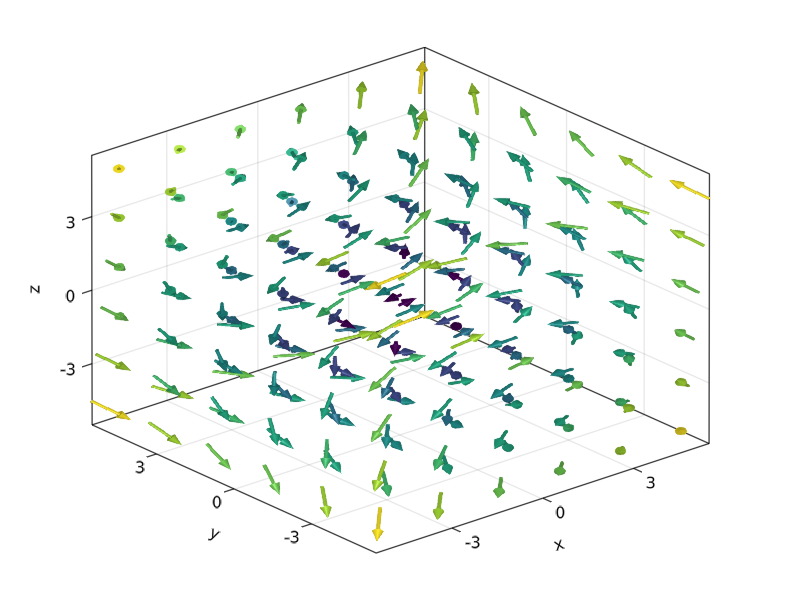

In [34]:
using GLMakie
using LinearAlgebra

ps = [Point3f(x, y, z) for x in -5:2:5 for y in -5:2:5 for z in -5:2:5]
ns = map(p -> 0.1 * Vec3f(p[2], p[3], p[1]), ps)
lengths = norm.(ns)
arrows(
    ps, ns, fxaa=true, # turn on anti-aliasing
    color=lengths,
    linewidth = 0.1, arrowsize = Vec3f(0.3, 0.3, 0.4),
    align = :center, axis=(type=Axis3,)
)

In [25]:
using GLMakie
using GeometryBasics

fig = Figure(resolution=(600, 600))
ax = Axis3(fig[1, 1]; perspectiveness=0.5)

sphere = Sphere(Point3f(0), 1)
spheremesh = GeometryBasics.mesh(Tesselation(sphere, 64))
mesh!(ax, spheremesh; color=(:white, 0.25), transparency=true)
display(fig)

GLMakie.Screen(...)

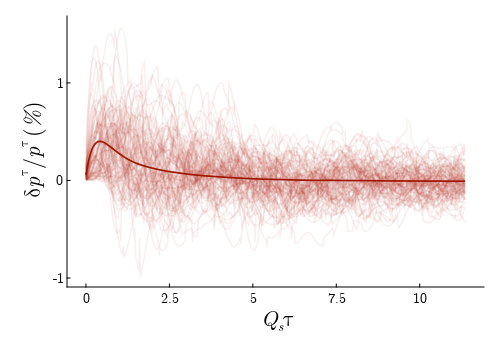

In [8]:
using CairoMakie
using ColorSchemes
using Statistics

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]
colors = [wesanderson[1], wesanderson[5]]

fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s \tau", ylabel=L"\delta p^\tau/p^\tau\,(%)",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

for i in 1:100
    rel_ptau_constraint = (ptau_constraint[:, i] .- pmu[:, i, 1])./pmu[:, i, 1].*100
    lines!(ax, tau*Qs/hbarc, rel_ptau_constraint, linewidth = 1.5, color=(colors[2], 0.07))
end

rel_ptau_constraint_all_part = (ptau_constraint .- pmu[:, :, 1])./pmu[:, :, 1].*100
mean_rel_ptau_constraint = vec(mean(rel_ptau_constraint_all_part, dims=2))
lines!(ax, tau*Qs/hbarc, mean_rel_ptau_constraint, linewidth = 1.7, color=colors[2])

# xlims!(ax, 0, 10)
ax.xticks = ([0, 2.5, 5, 7.5, 10], ["0", "2.5", "5", "7.5", "10"])
# ax.yticks = ([2.5, 5, 7.5, 10], ["2.5", "5", "7.5", "10"])

display(fig)
# save("final_ptau_constraint.png", fig, px_per_unit = 5.0) 

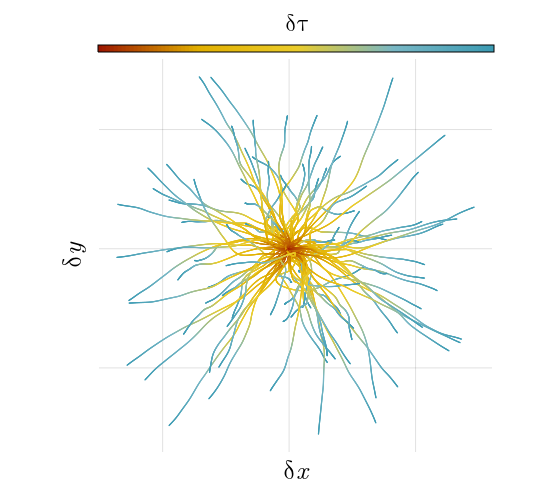

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000eccb840, 5500.0, 5000.0)


In [6]:
using CairoMakie
using ColorSchemes
using Statistics

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]
colors = [wesanderson[1], wesanderson[5]]

fig = Figure(resolution = (550, 500), font = "CMU Serif")
ax = Axis(fig[2, 1], aspect = 1,  
        xlabel=L"\delta x", ylabel=L"\delta y",
        rightspinevisible = false, topspinevisible = false, leftspinevisible = false, bottomspinevisible = false,
        leftspinecolor = :gray, bottomspinecolor = :gray,
        xlabelsize = 26, ylabelsize= 26, xticklabelsize=0, yticklabelsize=0,
        xtickalign = 1, xticksize=0, ytickalign=1, yticksize=0, xlabelpadding = -5, 
        # xlabelcolor = :gray, ylabelcolor = :gray, 
        xgridvisible = true, ygridvisible = true)

for i in 1:100
    δx, δy = xmu[:, i, 1].-xmu[1, i, 1], xmu[:, i, 2].-xmu[1, i, 2]
    global line = lines!(ax, δx, δy, linewidth = 1.2, color = tau, colormap = to_colormap(reverse(wesanderson)))
end

cbarline = Colorbar(fig, line, label = L"\delta\tau", labelsize=24, vertical = false, flipaxis = true, 
    ticksize=0, tickalign = 1, ticklabelsize = 0, width = Relative(3.32/4), height = 7)
fig[1, 1] = cbarline
rowgap!(fig.layout, 7)

# xlims!(ax, 0, 1)
# ticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
# ax.xticks = (ticks, string.(ticks))
# ax.yticks = (ticks, string.(ticks))

# ax.yticks = ([2.5, 5, 7.5, 10], ["2.5", "5", "7.5", "10"])

display(fig)
save("2d_glasma_spaghetti_v2.png", fig, px_per_unit = 10.0) 
# save("2d_glasma_spaghetti_v2.pdf", fig) 

In [ ]:
using Plots
# pgfplotsx()
using ColorSchemes
using LaTeXStrings
# using Makie
# using AbstractPlotting


wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]

for i in 1:100
    if i ==1
        # plot(pmu[:, i, 4], pmu[:, i, 2], pmu[:, i, 3], lc = to_colormap(reverse(wesanderson), length(tau)), linewidth = 1.5, legend = false)
        # plot(pmu[:, i, 5], pmu[:, i, 2], pmu[:, i, 3], linez = tau, color = cgrad(reverse(wesanderson)), linewidth = 1.3, legend = false, cbar=true, colorbar_title=L"\tau\,\mathrm{[fm/c]}")
        plot(pmu[:, i, 2], pmu[:, i, 3], pmu[:, i, 5], linez = tau, color = cgrad(reverse(wesanderson)), linewidth = 1.5, legend = false)
        # plot(pmu[:, i, 5], pmu[:, i, 2], pmu[:, i, 3], linewidth = 1.3, legend = false)
    else
        # plot!(pmu[:, i, 4], pmu[:, i, 2], pmu[:, i, 3], lc = to_colormap(reverse(wesanderson), length(tau)), linewidth = 1.5, legend = false)
        plot!(pmu[:, i, 2], pmu[:, i, 3], pmu[:, i, 5], linez = tau, color = cgrad(reverse(wesanderson)), linewidth = 1.5, legend = false)
        # plot!(pmu[:, i, 5], pmu[:, i, 2], pmu[:, i, 3], linewidth = 1.3, legend = false)
    end
end
# plot!()
plot!(aspect_ratio=1.0, size=(600,600), dpi=900)
# plot!(xlabel=L"p^z\,\mathrm{[GeV]}", ylabel=L"p^x\,\mathrm{[GeV]}", zlabel=L"p^y\,\mathrm{[GeV]}")
# plot!(xlabel=L"p^z\,\mathrm{[\,a.u.]}", ylabel=L"p^x\,\mathrm{[\,a.u.]}", zlabel=L"p^y\,\mathrm{[\,a.u.]}")
plot!(xlabel=L"p^x", ylabel=L"p^y", zlabel=L"p^z")
# plot!(labelfontsize=16, tickfontsize=12, colorbar_titlefontsize=20, colorbar_tickfontsize=10)
plot!(labelfontsize=18, tickfontsize=1, tickfontcolor=:white)
# plot!(showaxis=:x)
# plot!(camera=(50,20))

# plot!(guidefontcolor=:gray)

# plot!(foreground_color_border=:gray)
plot!(foreground_color_border=:white)
plot!(tick_dir=:none)
# plot!(grid=false)
# plot(p1, p2)
savefig("3d_glasma_noodles_v2.png")
# savefig("3d_glasma_noodles_v2.pdf")

In [ ]:
using Plots
# pgfplotsx()
using ColorSchemes
using LaTeXStrings

wesanderson = ["#3c9bb3", "#78b7c5", "#ebcc2a", "#e1af00", "#9d1700"]

for i in 1:10
    if i ==1
        plot(pmu[:, i, 2], pmu[:, i, 3], pmu[:, i, 5], linez = tau, color = cgrad(reverse(wesanderson)), linewidth = 1.5, legend = false)
    else
        plot!(pmu[:, i, 2], pmu[:, i, 3], pmu[:, i, 5], linez = tau, color = cgrad(reverse(wesanderson)), linewidth = 1.5, legend = false)
    end
end
# plot!()
plot!(aspect_ratio=1.0, size=(600,600), dpi=600)
plot!(xlabel=L"Q_1", ylabel=L"Q_2", zlabel=L"Q_3")
plot!(labelfontsize=18, tickfontsize=1, tickfontcolor=:white)
plot!(guidefontcolor=:gray)
plot!(foreground_color_border=:white)
plot!(tick_dir=:none)
# savefig("3d_glasma_noodles.png")

---
### Plots for article

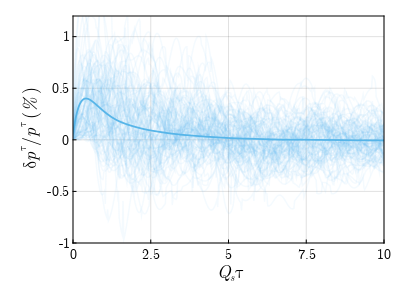

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000a632200, 300.0, 225.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/ptau_constraint_final.pdf>)))


In [8]:
using CairoMakie
using ColorSchemes
using Statistics

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 300), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s \tau", ylabel=L"\delta p^\tau/p^\tau\,(%\,)",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5, )

for i in 1:100
    rel_ptau_constraint = (ptau_constraint[:, i] .- pmu[:, i, 1])./pmu[:, i, 1].*100
    lines!(ax, tau*Qs/hbarc, rel_ptau_constraint, linewidth = width_line, color=(colors[3], 0.07))
end

rel_ptau_constraint_all_part = (ptau_constraint .- pmu[:, :, 1])./pmu[:, :, 1].*100
mean_rel_ptau_constraint = vec(mean(rel_ptau_constraint_all_part, dims=2))
lines!(ax, tau*Qs/hbarc, mean_rel_ptau_constraint, linewidth = 1.8, color=colors[3])

xlims!(ax, 0, 10)
ylims!(ax, -1, 1.2)
ax.xticks = ([0, 2.5, 5, 7.5, 10], ["0", "2.5", "5", "7.5", "10"])
ax.yticks = ([-1, -0.5, 0, 0.5, 1], ["-1", "-0.5", "0", "0.5", "1"])

display(fig)
save("ptau_constraint_final.pdf", fig) 

---
### Old scripts

## Import plotting packages

In [9]:
import matplotlib.pyplot as plt

plt.style.use('nord_theme.mpltstyle')

# Casimir invariants

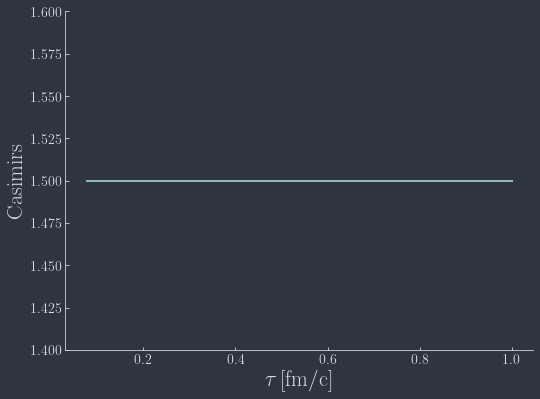

In [17]:
plt.rcParams["figure.figsize"] = (8, 6)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
colors = ['#8FBCBB', '#B48EAD']
for i in range(500):
    for ci in range(su.CASIMIRS):
        plt.plot(tau, casimirs[:, i, ci], color=colors[ci])

plt.ylabel(r'$\mathrm{Casimirs}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.tight_layout()

# range for SU(2)
if su_group=='su2':
    plt.ylim([1.4, 1.6])

# $p^\tau$ constraint

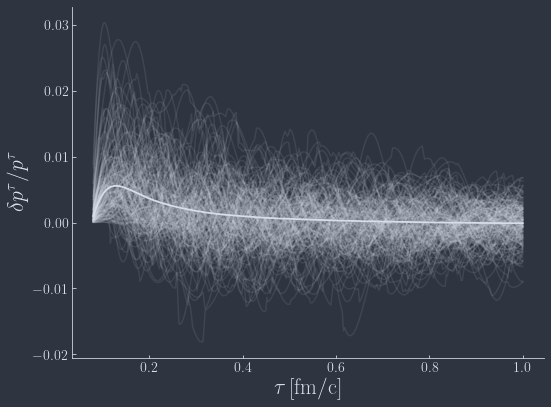

In [11]:
plt.rcParams["figure.figsize"] = (8, 6)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
for i in range(200):
    rel_ptau_constraint = (ptau_constraint[:, i] - pmu[:, i, 0])/pmu[:, i, 0]
    plt.plot(tau, rel_ptau_constraint, color='#D8DEE9', alpha=0.1)

rel_ptau_constraint_all_part = (ptau_constraint - pmu[:, :, 0])/pmu[:, :, 0]
mean_rel_ptau_constraint = np.mean(rel_ptau_constraint_all_part, axis=1)
plt.plot(tau, mean_rel_ptau_constraint, color='#D8DEE9', linewidth=1.8)

plt.ylabel(r'$\delta p^\tau/p^\tau$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.tight_layout()
# plt.savefig('ptau_constraint.png', dpi=300, transparent=False)

# Plot positions

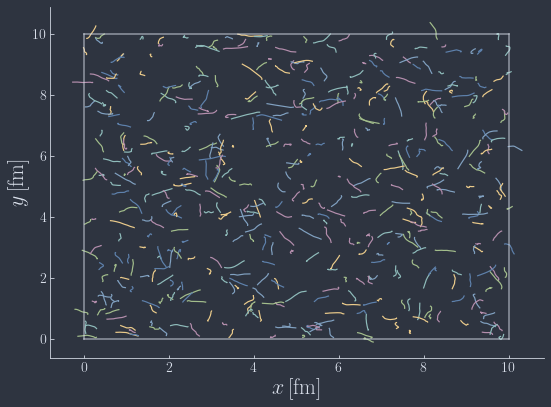

In [18]:
plt.rcParams["figure.figsize"] = (8, 6)

for i in range(500):
    plt.plot(xmu[:, i, 0] * a, xmu[:, i, 1] * a, linewidth=1.2)

border = np.linspace(0, L, N)
plt.plot(border, np.zeros(N), color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(np.zeros(N), border, color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(border, L*np.ones(N), color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(L*np.ones(N), border, color='#D8DEE9', alpha=0.6, linewidth=1.5)

plt.ylabel(r'$y\,\mathrm{[fm]}$')
plt.xlabel(r'$x\,\mathrm{[fm]}$')
plt.tight_layout()

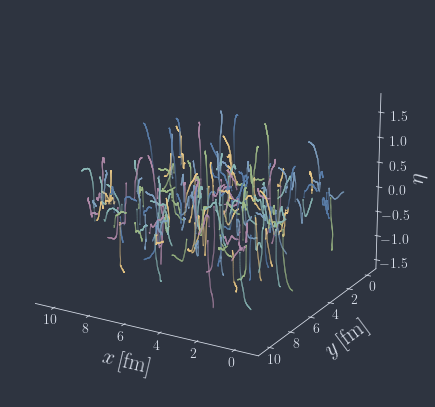

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(200):
    ax.scatter(xmu[:, i, 0] * a, xmu[:, i, 1] * a, xmu[:, i, 2], xmu[:, i, 2], s=0.02)

ax.set_xlabel(r'$x\,\mathrm{[fm]}$')
ax.set_ylabel(r'$y\,\mathrm{[fm]}$')
ax.set_zlabel(r'$\eta$')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#2E3440')
ax.yaxis.pane.set_edgecolor('#2E3440')
ax.zaxis.pane.set_edgecolor('#2E3440')

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)

ax.view_init(20, 120)
plt.tight_layout()

# Plot momenta

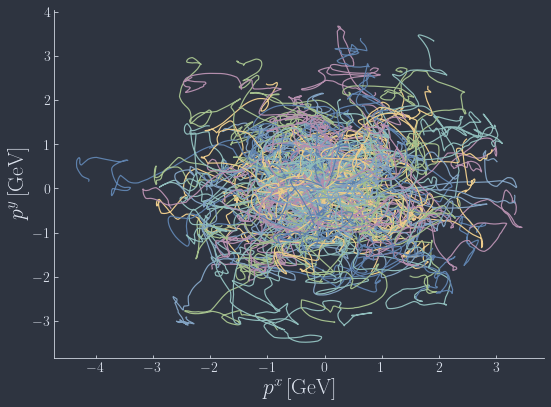

In [12]:
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 1)

for i in range(200):
    plt.plot(pmu[:, i, 1] * E0, pmu[:, i, 2] * E0, linewidth=1.2)

plt.ylabel(r'$p^y\,\mathrm{[GeV]}$')
plt.xlabel(r'$p^x\,\mathrm{[GeV]}$')

plt.tight_layout()

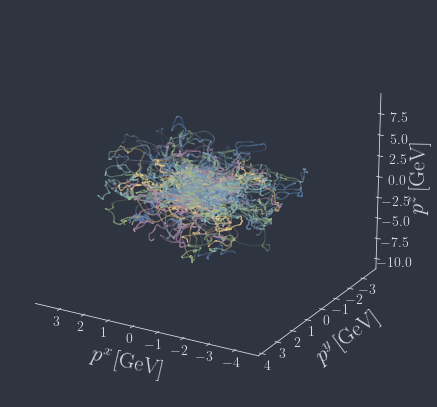

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(200):
    ax.scatter(pmu[:, i, 1] * E0, pmu[:, i, 2] * E0, pmu[:, i, 4] * E0, pmu[:, i, 4] * E0, s=0.02)

ax.set_xlabel(r'$p^x\,\mathrm{[GeV]}$')
ax.set_ylabel(r'$p^y\,\mathrm{[GeV]}$')
ax.set_zlabel(r'$p^z\,\mathrm{[GeV]}$')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#2E3440')
ax.yaxis.pane.set_edgecolor('#2E3440')
ax.zaxis.pane.set_edgecolor('#2E3440')

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)
# ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# ax.xaxis.set_major_locator(plt.MaxNLocator(5))

ax.view_init(20, 120)
plt.tight_layout()

## Plot momentum broadenings

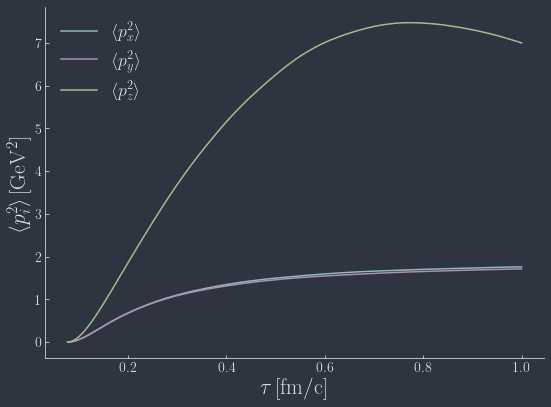

In [14]:
plt.rcParams["figure.figsize"] = (8, 6)
# fig, ax = plt.subplots(1, 1)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
plt.plot(tau, p_sq_mean[:, 0] * E0**2, label=r'$\langle p_x^2\rangle$')
plt.plot(tau, p_sq_mean[:, 1] * E0**2, label=r'$\langle p_y^2\rangle$')
plt.plot(tau, p_sq_mean[:, 2] * E0**2, label=r'$\langle p_z^2\rangle$')

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.ylabel(r'$\langle p_i^2\rangle \,\mathrm{[GeV^2]}$')

plt.legend()
plt.tight_layout()